In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


# 1.Data Preprocessing
 <ul>
    <li>initialize the initial learning rate, number of epochs to train for, and batch size<</li>
    
 </ul>

        

In [6]:
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

DIRECTORY = r"D:\fm\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)


[INFO] loading images...


c:\users\kotha sai\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# 2.Train_test_split

splitting data arrays into two subsets: for training data and for testing data. by using train_test_split

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


# 3.Model Building

 <ul>
    <li>load the MobileNetV2 network, ensuring the head FC layer sets are</li>
    <li>construct the head of the model that will be placed on top of the</li>
    <li>place the head FC model on top of the base model (this will become the actual model we will train)</li>
    <li>loop over all layers in the base model and freeze them so they will *not* be updated during the first training process</li>
    <li>compile our model</li>

 </ul>


In [25]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


# 4.train the head of the network and visualization



In [26]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=5)



[INFO] training head...
Epoch 1/5
95/95 [==============================] - 82s 863ms/step - loss: 0.3865 - accuracy: 0.8329 - val_loss: 0.1033 - val_accuracy: 0.9765
Epoch 2/5
95/95 [==============================] - 84s 889ms/step - loss: 0.1199 - accuracy: 0.9591 - val_loss: 0.0573 - val_accuracy: 0.9870
Epoch 3/5
95/95 [==============================] - 90s 948ms/step - loss: 0.0851 - accuracy: 0.9726 - val_loss: 0.0439 - val_accuracy: 0.9870
Epoch 4/5
95/95 [==============================] - 96s 1s/step - loss: 0.0718 - accuracy: 0.9773 - val_loss: 0.0386 - val_accuracy: 0.9883
Epoch 5/5
95/95 [==============================] - 92s 966ms/step - loss: 0.0620 - accuracy: 0.9806 - val_loss: 0.0403 - val_accuracy: 0.9883


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model3", save_format="h5")

# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot3.png")


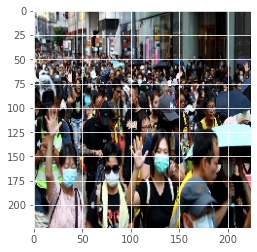

In [23]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'D:\fm\image-1.jpg', target_size = (224, 224))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = preprocess_input(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

In [24]:
result

array([[0.97682136, 0.02317857]], dtype=float32)

Here in the above result variable the '0' index value is greater than the '1' index value so mask is present with accuracy 97 percent.

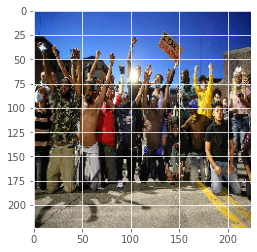

In [21]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'D:\fm\image-2.jpg', target_size = (224, 224))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = preprocess_input(test_image)
test_image = np.expand_dims(test_image, axis=0)
result2 = model.predict(test_image)

In [22]:
result2

array([[0.5386195, 0.4613805]], dtype=float32)

In the above result2 variable the '0' index value is greater than the '1' index value so mask is present with accuracy 53 percent.